<a href="https://colab.research.google.com/github/mritogether/ESMRMB2024_Hardware_to_Map/blob/main/03_full_acquisition_simulations/notebooks/Talk2/ESMRMB_ET03_MRzero_to_the_rescue_Basic_sequences.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MRzero: Basic sequences**


In this notebook, MRzero simulation is used to simulate FLASH and EPI sequences. The sequence files are written with pypulseq.

**1. Install and import libraries**

In [37]:
!pip install pypulseq==1.4.2 &> /dev/null
!pip install MRzeroCore &> /dev/null
!wget https://github.com/MRsources/MRzero-Core/raw/main/documentation/playground_mr0/numerical_brain_cropped.mat &> /dev/null

In [38]:
import numpy as np
# newer numpy versions don't contain this, but pypulseq still relies on it
np.int = int
np.float = float
np.complex = complex

import MRzeroCore as mr0
import pypulseq as pp
import torch
import matplotlib.pyplot as plt
import os
from google.colab import output

plt.rcParams['figure.dpi'] = 100

**2. Prepare scanner**

In [39]:
system = pp.Opts(
    max_grad=80,
    grad_unit='mT/m',
    max_slew=200,
    slew_unit='T/m/s',
    rf_ringdown_time=30e-6,
    rf_dead_time=100e-6,
    adc_dead_time=20e-6,
    grad_raster_time=10e-6
)

**3. Acquisition conditions**

In [40]:
fov, slice_thickness = 200e-3, 8e-3#m
Nread, Nphase = 64, 64

**4. Construct sequence with pypulseq and save**

In [41]:
def aux_check_timing(seq):
  (ok,error_report,) = seq.check_timing()  # Check whether the timing of the sequence is correct
  if ok:
      print("Timing check passed successfully")
  else:
      print("Timing check failed. Error listing follows:")
      [print(e) for e in error_report]

def create_folder(directory):
  if not os.path.exists(directory):
    os.makedirs(directory)

def plot_signal_seq(seq, signal):
  plt.figure()
  plt.plot(np.imag(signal), label = "Imag(signal)")
  plt.plot(np.real(signal), label = "Real(signal)")
  plt.plot(np.abs(signal), label = "Abs(signal)")
  plt.xlabel("Time (a.u.)")
  plt.legend()
  plt.savefig("Signal.jpg")
  plt.close()

- FLASH  sequence

Timing check passed successfully


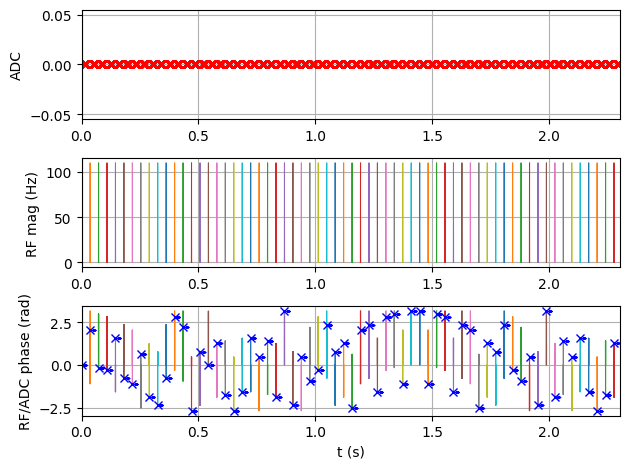

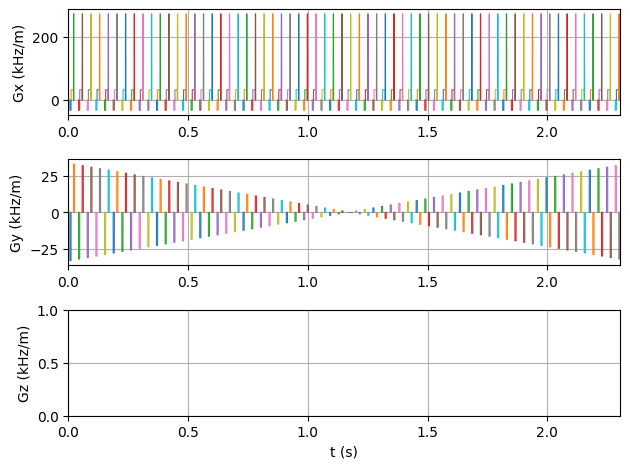

In [42]:
seq_FLASH = pp.Sequence()

# Define rf events
rf1, _, _ = pp.make_sinc_pulse(
    flip_angle=10 * np.pi / 180, duration=1e-3,
    slice_thickness=slice_thickness, apodization=0.5, time_bw_product=4,
    system=system, return_gz=True
)

# Define other gradients and ADC events
adc_duration_OG = 10e-3
adc_duration = ((adc_duration_OG / Nread)// system.grad_raster_time) * Nread * system.grad_raster_time

gx = pp.make_trapezoid(channel='x', flat_area=Nread / fov, flat_time=10e-3, system=system)
adc = pp.make_adc(num_samples=Nread, duration=adc_duration, phase_offset=0 * np.pi/180, delay=gx.rise_time, system=system)
gx_pre = pp.make_trapezoid(channel='x', area=-gx.area / 2, duration=5e-3, system=system)
gx_spoil = pp.make_trapezoid(channel='x', area=1.5 * gx.area, duration=2e-3, system=system)

rf_phase = 0
rf_inc = 0
rf_spoiling_inc = 117

##linear reordering
phenc = np.arange(-Nphase // 2, Nphase // 2, 1) / fov
permvec =np.arange(0, Nphase, 1)
phenc_centr = phenc[permvec]

for ii in range(0, Nphase):  # e.g. -64:63

    rf1.phase_offset = rf_phase / 180 * np.pi   # set current rf phase

    adc.phase_offset = rf_phase / 180 * np.pi  # follow with ADC
    rf_inc = divmod(rf_inc + rf_spoiling_inc, 360.0)[1]   # increase increment
    # increment additional pahse
    rf_phase = divmod(rf_phase + rf_inc, 360.0)[1]

    seq_FLASH.add_block(rf1)
    seq_FLASH.add_block(pp.make_delay(0.005))
    gp = pp.make_trapezoid(channel='y', area=phenc_centr[ii], duration=5e-3, system=system)
    seq_FLASH.add_block(gx_pre, gp)
    seq_FLASH.add_block(adc, gx)
    gp = pp.make_trapezoid(channel='y', area=-phenc_centr[ii], duration=5e-3, system=system)
    seq_FLASH.add_block(gx_spoil, gp)
    if ii < Nphase - 1:
        seq_FLASH.add_block(pp.make_delay(0.01))

aux_check_timing(seq_FLASH)
seq_FLASH.write("FLASH.seq")
seq_FLASH.plot()


- EPI

Timing check passed successfully


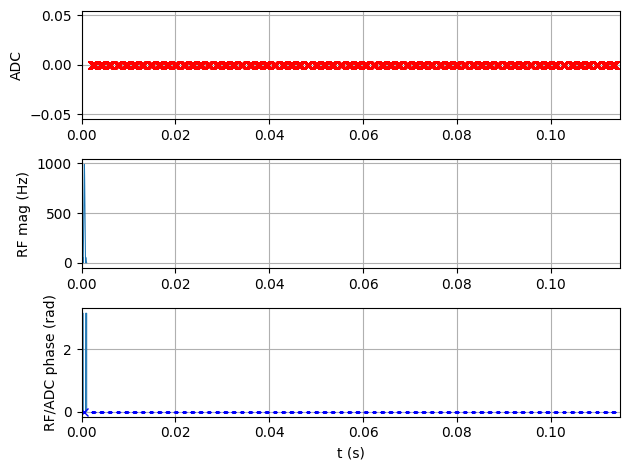

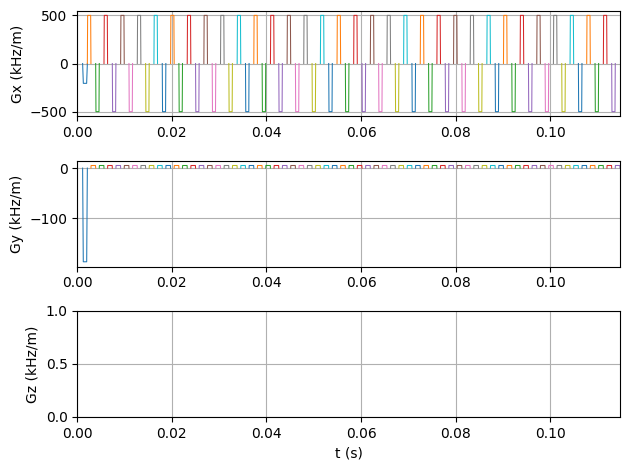

In [50]:
seq_EPI = pp.Sequence()

# Define rf events
rf1, _, _ = pp.make_sinc_pulse(
    flip_angle=90 * np.pi / 180, duration=1e-3,
    slice_thickness=slice_thickness, apodization=0.5, time_bw_product=4,
    system=system, return_gz=True
)

# Define other gradients and ADC events
adc_duration_OG = 1e-3
adc_duration = ((adc_duration_OG / Nread)// system.grad_raster_time) * Nread * system.grad_raster_time

gx = pp.make_trapezoid(channel='x', flat_area=Nread / fov, flat_time=adc_duration, system=system)
gx_ = pp.make_trapezoid(channel='x', flat_area=-Nread / fov, flat_time=adc_duration, system=system)
adc = pp.make_adc(num_samples=Nread, duration=adc_duration, phase_offset=0 * np.pi / 180, delay=gx.rise_time, system=system)
gx_pre = pp.make_trapezoid(channel='x', area=-gx.area / 2, duration=1e-3, system=system)

gp_blip = pp.make_trapezoid(channel='y', area=1 / fov, duration=1e-3, system=system)

seq_EPI.add_block(rf1)
gp = pp.make_trapezoid(channel='y', area=-Nphase//2 / fov, duration=1e-3, system=system)
seq_EPI.add_block(gx_pre, gp)

for ii in range(0, Nphase//2):
    seq_EPI.add_block(gx,adc)
    seq_EPI.add_block(gp_blip)
    seq_EPI.add_block(gx_,adc)
    seq_EPI.add_block(gp_blip)
aux_check_timing(seq_EPI)
seq_EPI.write("EPI.seq")
seq_EPI.plot()

**5. Prepare digital phantom**

VoxelGridPhantom
size = tensor([0.2000, 0.2000, 0.0080])


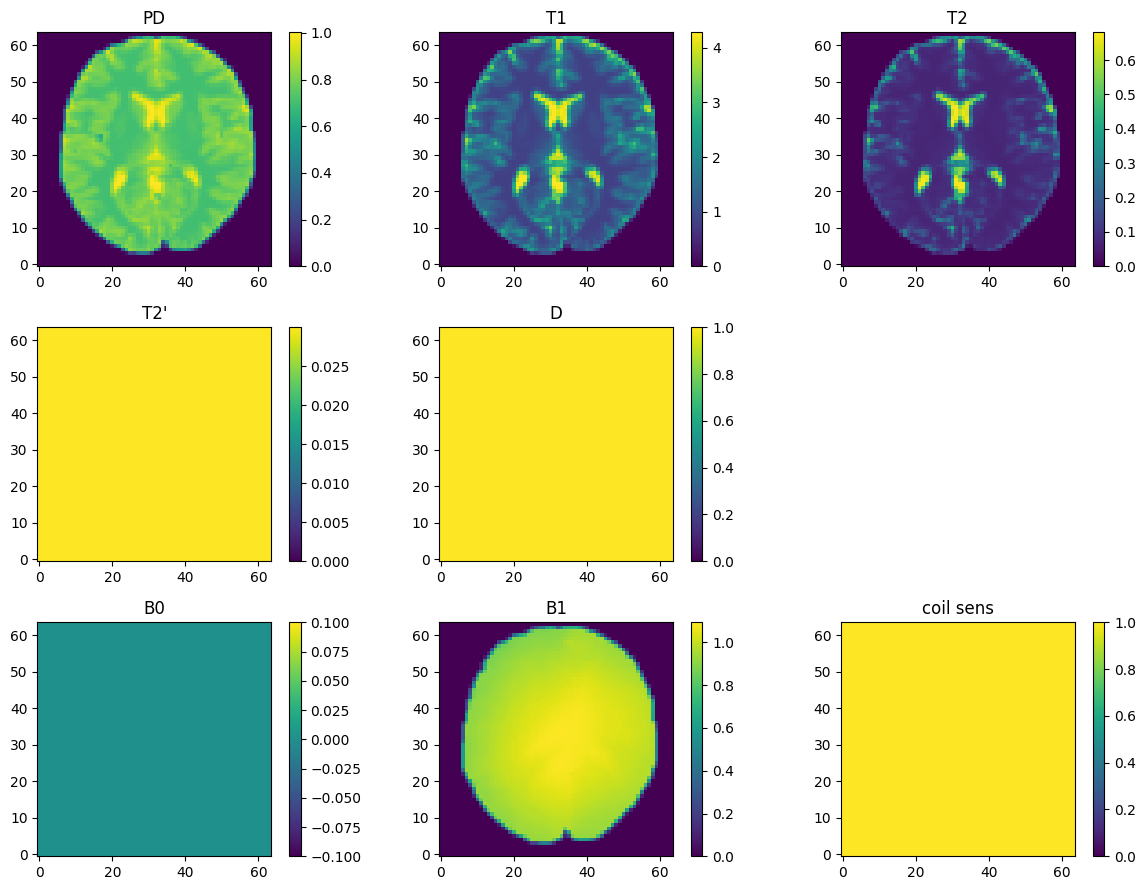

In [51]:
sz = [Nread, Nread]
phantom = mr0.VoxelGridPhantom.load_mat('numerical_brain_cropped.mat')
phantom = phantom.interpolate(sz[0], sz[1], 1)
# Convert Phantom into simulation data
phantom.B0[:] = 0
obj_p = phantom.build()

phantom.plot()

**6. Load as MRzero sequence object and simulate signal acquisition**

Calculating repetition 64 / 64 - done


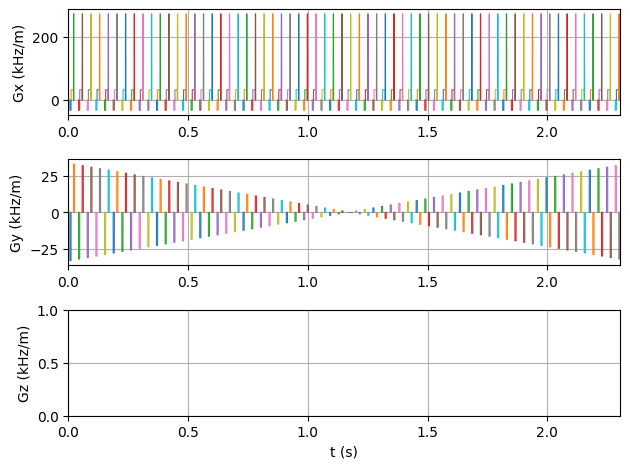

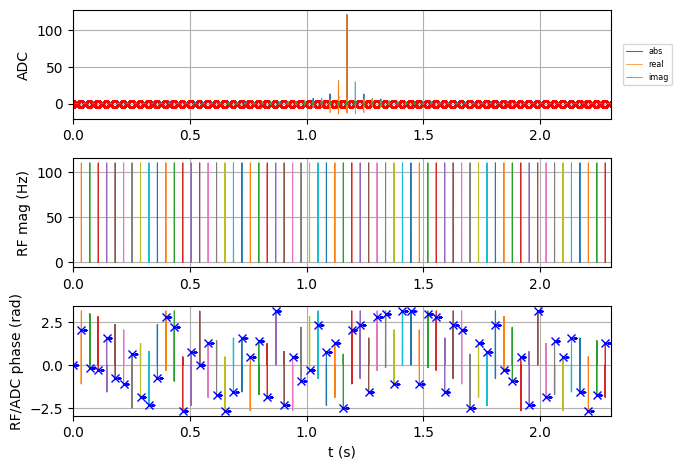

In [52]:
# FLASH
seq0_FLASH = mr0.Sequence.import_file('FLASH.seq')
graph_FLASH = mr0.compute_graph(seq0_FLASH, obj_p, 200, 1e-3)
signal_FLASH = mr0.execute_graph(graph_FLASH, seq0_FLASH, obj_p)
seq_FLASH.plot(plot_now = False)
mr0.util.insert_signal_plot(seq_FLASH, signal_FLASH.numpy())

Calculating repetition 1 / 1 - done


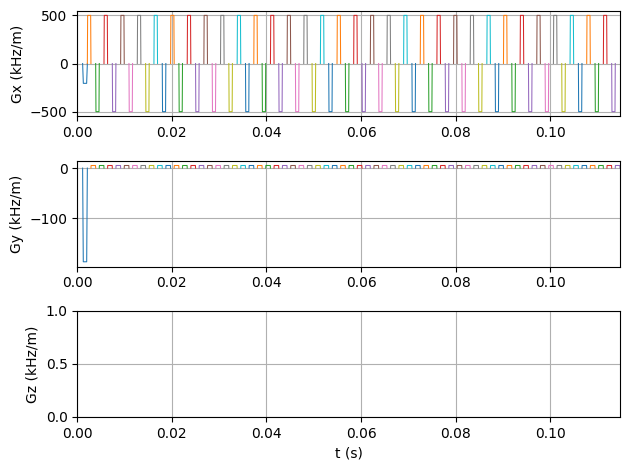

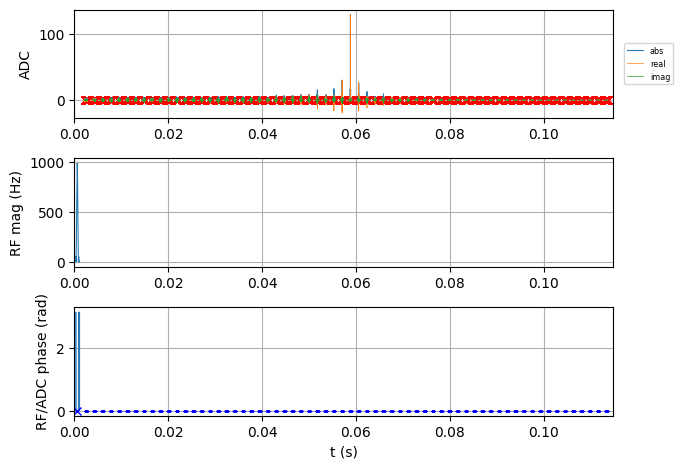

In [53]:
# EPI
seq0_EPI = mr0.Sequence.import_file('EPI.seq')
graph_EPI = mr0.compute_graph(seq0_EPI, obj_p, 200, 1e-3)
signal_EPI = mr0.execute_graph(graph_EPI, seq0_EPI, obj_p)
seq_EPI.plot(plot_now = False)
mr0.util.insert_signal_plot(seq_EPI, signal_EPI.numpy())

**7. Image reconstruction**

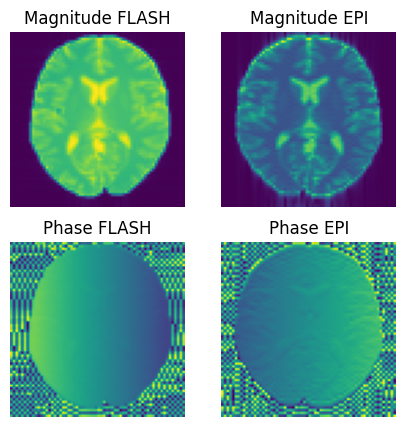

In [54]:
# FLASH reconstruction
ipermvec = np.argsort(permvec)
kspace_FLASH = torch.reshape((signal_FLASH), (Nphase, Nread)).clone().t()
kspace_FLASH=kspace_FLASH[:,ipermvec]

# fftshift
spectrum_FLASH = torch.fft.fftshift(kspace_FLASH)
# FFT
space_FLASH = torch.fft.fft2(spectrum_FLASH)
# fftshift
space_FLASH = torch.fft.ifftshift(space_FLASH)

# EPI reconstruction
kspace_EPI = torch.reshape((signal_EPI), (Nphase, Nread)).clone().t()
kspace_EPI[:,0::2] = torch.flip(kspace_EPI[:,0::2],[0] )[:,:]

# fftshift
spectrum_EPI = torch.fft.fftshift(kspace_EPI)
# FFT
space_EPI = torch.fft.fft2(spectrum_EPI)
# fftshift
space_EPI = torch.fft.ifftshift(space_EPI)
#plt.rcParams['figure.dpi'] = 300
fig_recon = plt.figure(figsize = [5,5])
plt.subplot(2,2,1)
plt.imshow(np.rot90(abs(space_FLASH)))
plt.axis("off")
plt.title("Magnitude FLASH")
plt.subplot(2,2,3)
plt.imshow(np.rot90(np.angle(space_FLASH)))
plt.axis("off")
t = plt.title("Phase FLASH")
plt.subplot(2,2,2)
plt.imshow(np.rot90(abs(space_EPI)))
plt.axis("off")
plt.title("Magnitude EPI")
plt.subplot(2,2,4)
plt.imshow(np.rot90(np.angle(space_EPI)))
plt.axis("off")
t = plt.title("Phase EPI")